In [54]:
import numpy as np
import pandas as pd
import QuantLib as ql
import matplotlib.pyplot as plt
import datetime
import statsmodels.api as sm
plt.style.use('seaborn-whitegrid')
from curve import marketData
from IPython.display import Image

In [169]:
def timeFromReferenceFactory(daycounter, ref):
    def impl(dat):
        return daycounter.yearFraction(ref, dat)
    return np.vectorize(impl)

def makeSwap(start, maturity, notional, fixedRate, index, tipo = ql.VanillaSwap.Payer):
    """
    Returns the Quantlib swap object
    """
    fixedLegTenor = ql.Period("6m")
    fixedLegBDC = ql.ModifiedFollowing
    floatLegTenor = index.tenor()
    fixedLegDC = index.dayCounter() #ql.Thirty360(ql.Thirty360.BondBasis)
    spread = 0.0
    fixedSchedule = ql.Schedule(start, maturity, fixedLegTenor, index.fixingCalendar(), fixedLegBDC, fixedLegBDC, 
                                   ql.DateGeneration.Backward, False)
    floatSchedule = ql.Schedule(start, maturity, floatLegTenor, index.fixingCalendar(), index.businessDayConvention(),
                                    index.businessDayConvention(), ql.DateGeneration.Backward,False)
    swap = ql.VanillaSwap(tipo, notional,fixedSchedule,fixedRate,fixedLegDC,floatSchedule,index,spread,index.dayCounter())
    return swap
 #   """
 #      Input:
 #      - swap: ql.VanillaSwap Object
 #      - data: reference date
 #      Returns:
 #      - array of payment times for the fixed leg 
 #      - array of cash flows for the fixed leg 
 #  """
 #      
def getfixed(swap, data):
    """
        Input:
        - swap: ql.VanillaSwap Object
        - data: reference date
        Returns:
        - array of payment times for the fixed leg 
        - array of cash flows for the fixed leg 
    """
    date_temp = calendar.advance(data, -callability) 
    time_temp = ql.Actual365Fixed().yearFraction(today,date_temp)
    t = time_temp
    fixed_leg = swap.leg(0)
    n = len(fixed_leg)
    fixed_times=[]
    fixed_amounts=[]
    if n == len(date_grid):
        for i in range(n):
            refDate = calendar.advance(date_grid[i], callability) 
            cf = fixed_leg[i]
            cf_time = daycounter.yearFraction(refDate, cf.date() )
            t_i = timeFromReference(cf.date())
            if t_i > t:
                fixed_times.append(t_i)
                fixed_amounts.append(cf.amount())
        fixed_times = np.array(fixed_times)
        fixed_amounts = np.array(fixed_amounts)
    else: 
        for i in range(n):
            cf = fixed_leg[i]
            t_i = timeFromReference(cf.date())
            if t_i > t:
                fixed_times.append(t_i)
                fixed_amounts.append(cf.amount())
        fixed_times = np.array(fixed_times)
        fixed_amounts = np.array(fixed_amounts)
    return fixed_times, fixed_amounts

  #   """
#    Input:
#    - swap: ql.VanillaSwap Object
#    - data: reference date
#    
#    Returns:
#    - array --> payment times for the floating leg
#    - array --> accrual between payments
#    - array --> start of the accruals
#    - array --> end of the accruals
#    - array --> notionals
 #   """
def getfloating(swap, data):
    """
    Input: 
        - swap: ql.VanillaSwap Object
    - data: reference date
    
    Returns:
    - array --> payment times for the floating leg
    - array --> accrual between payments
    - array --> start of the accruals
    - array --> end of the accruals
    - array --> notionals
    """
    float_leg = swap.leg(1)
    t = ql.Actual365Fixed().yearFraction(today,data)
    n = len(float_leg)
    float_times = []
    float_dcf = []
    accrual_start_time = []
    accrual_end_time = []
    nominals = []
    for i in range(n):
        cf = ql.as_floating_rate_coupon(float_leg[i])
        value_date = cf.referencePeriodStart()
        t_fix_i = timeFromReference(value_date)
        t_i = timeFromReference(cf.date()) 
        if t_fix_i >= t:
            iborIndex = cf.index()
            index_mat = cf.referencePeriodEnd()
            float_dcf.append(cf.accrualPeriod())
            accrual_start_time.append(t_fix_i)
            accrual_end_time.append(timeFromReference(index_mat))
            float_times.append(t_i)
            nominals.append(cf.nominal())
    return np.array(float_times), np.array(float_dcf), np.array(accrual_start_time), np.array(accrual_end_time), np.array(nominals)

def swapPathNPV(swap, data):
    """
    Input:
    - swap: ql.VanillaSwap Object
    - data: reference date

    Returns:
    function calc(x_t)
        input:
        - x_t --> level of the state variable (short rate) 
    """
    fixed_times, fixed_amounts = getfixed(swap, data)
    float_times, float_dcf, accrual_start_time, accrual_end_time, nominals = getfloating(swap, data)
    t = ql.Actual365Fixed().yearFraction(today,data)
    df_times = np.concatenate([fixed_times, accrual_start_time, accrual_end_time, float_times])
    df_times = np.unique(df_times)
    # Store indices of fix leg payment times in the df_times array
    fix_idx = np.in1d(df_times, fixed_times, True)
    fix_idx = fix_idx.nonzero()
    # Indices of the floating leg payment times in the df_times array
    float_idx = np.in1d(df_times, float_times, True)
    float_idx = float_idx.nonzero()
    # Indices of the accrual start and end time in the df_times array
    accrual_start_idx = np.in1d(df_times, accrual_start_time, True)
    accrual_start_idx = accrual_start_idx.nonzero()
    accrual_end_idx = np.in1d(df_times, accrual_end_time, True)
    accrual_end_idx = accrual_end_idx.nonzero()
    # Calculate NPV
    def calc(x_t):
        discount = np.vectorize(lambda T: model.zerobond(T, t, x_t))
        dfs = discount(df_times)
        # Calculate fixed leg npv
        fix_leg_npv = np.sum(fixed_amounts * dfs[fix_idx])
        # Estimate the index fixings
        index_fixings = (dfs[accrual_start_idx] / dfs[accrual_end_idx] - 1) 
        index_fixings /= float_dcf
        # Calculate the floating leg npv
        float_leg_npv = np.sum(nominals * index_fixings * float_dcf * dfs[float_idx])
        npv = float_leg_npv - fix_leg_npv
        return npv ,float_leg_npv, fix_leg_npv
    return calc

def short_rate_path(time_grid):
    """
     Input:
    - time_grid: simulation times in years

    Returns:
    r_t --> one path for the short rate (Hull-White)
    r_std --> standardized variable (useful later for approximation)
    numeraire --> The numeraire for the T-measure (the ql.Gsr process is written under the T-Forward measure)
    """
    m = len(time_grid)
    r_t = np.zeros(m)
    r_std = np.zeros(m)
    numeraire = np.zeros(m)
    for i in range(1, m):
        numeraire[0] = model.numeraire(0,0)
        t0 = time_grid[i-1]
        t1 = time_grid[i]
        e = process.expectation(t0, r_t[i-1], dt[i-1])
        std = process.stdDeviation(t0, r_t[i-1], dt[i-1])
        r_t[i] = np.random.normal(loc= e, scale= std)
        e_0_0 = process.expectation(0,0,t1)
        std_0_0 = process.stdDeviation(0,0,t1)
        r_std[i] = (r_t[i] - e_0_0) / std_0_0
        numeraire[i] = model.numeraire(t1, r_std[i])
    return r_t, r_std, numeraire

def swapSimulation(nPath):
    """
    Input:
    - nPath: number of paths for Monte Carlo

    Returns:
    - swapNPV: future values of the swap
    - flt: future values of the floating leg
    - fix: future values of the fixed leg
    - numeraires: numeraires for all paths
    - r_std: standardized short rate
    - r_t: short rate simulation
    """
    m = len(time_grid)
    r_t = np.zeros((nPath, m))
    r_std = np.zeros((nPath, m))
    numeraires = np.zeros((nPath, m))
    swapNPV = np.zeros((nPath, m))
    flt = np.zeros((nPath, m))
    fix = np.zeros((nPath, m))
    for i in range(nPath):
        r_t[i], r_std[i], numeraires[i]= short_rate_path(time_grid)
    for i in range(len(date_grid)):
        swapNPV[:,i],flt[:,i],fix[:,i] = np.vectorize(swapPathNPV(swap, date_grid[i]))(r_std[:,i])
    return swapNPV, flt, fix, numeraires, r_std, r_t

def LSM_american(nPath):
    """
    Input: 
    - nPath: number of paths
    
    Returns:
    - npv_amc: Least Squares Monte Carlo valuation
    - stDev_percentage: Standard deviation of the simulation
    - exerciseProbability: exercise probability of the option
    """
    swapNPV, flt, fix, numeraires, y, r = swapSimulation(nPath)
    payoff = swapNPV[:,-1]/numeraires[:,-1]
    payoff[payoff < 0] = 0
    V = np.zeros_like(y)
    exerciseProbability = np.zeros_like(y)
    V[:,-1] = payoff
    m = len(time_grid) -1
    ols_res = []
    for i in range(m-1, 0, -1):
        exercise_values = swapNPV[:,i] / numeraires[:,i]
        exercise_values[exercise_values < 0] = 0
        states = y[:, i]
        Y = np.column_stack((states, states**2, states**3, states**4))
        Y = sm.add_constant(Y)
        ols = sm.OLS(V[:,i+1], Y)   
        ols_result = ols.fit()
        ols_res.append(ols_result)
        cont_value_hat = np.sum(ols_result.params * Y, axis=1)
        exerciseProbability[:,i]= np.where(exercise_values > cont_value_hat,1,0)
        V[:,i] = np.maximum(cont_value_hat, exercise_values)
    npv_amc =  np.sum(V[:,1]*numeraires[0,0]) / nPath 
    stDev_simulation = np.sqrt((np.sum((V[:,1]*numeraires[0,0] - npv_amc)**2))/nPath)
    stDev_percentage = stDev_simulation / npv_amc
    exerciseProbability = np.sum(exerciseProbability, axis = 0)/nPath
    return npv_amc, stDev_percentage, exerciseProbability

#### Input iniziali, le curve vengono importate da un altro foglio

In [140]:
today = ql.Date.from_date(datetime.datetime.now())
ql.Settings.instance().setEvaluationDate(today)
rate = ql.SimpleQuote(0.03)
rate_handle = ql.QuoteHandle(rate)
daycount = ql.Actual365Fixed()
#yieldTermStructure = ql.FlatForward(today, rate_handle, daycount)
yieldTermStructure = marketData.EUR6M.qlDiscountCurve()
yieldTermStructure.enableExtrapolation()
handleYieldTermStructure = ql.RelinkableYieldTermStructureHandle(yieldTermStructure)
t0_curve = ql.YieldTermStructureHandle(yieldTermStructure)
index = ql.Euribor6M(handleYieldTermStructure)
calendar = ql.TARGET()
daycounter = yieldTermStructure.dayCounter()
timeFromReference = timeFromReferenceFactory(daycounter, today)

#### parametri Hull-White

In [141]:
volas = [ql.QuoteHandle(ql.SimpleQuote(0.0040)),
         ql.QuoteHandle(ql.SimpleQuote(0.0040))]
meanRev = [ql.QuoteHandle(ql.SimpleQuote(0.05))]
model = ql.Gsr(t0_curve, [today+100], volas, meanRev, 31.)
process = model.stateProcess()

#### Vanilla swap ATM spot starting(= default Murex), maturity 5y, call dates -10d dai pagamenti della gamba fissa

In [171]:
notional = 1e6
fixedRate = -0.0015335102098061118
settlementDate = calendar.advance(today, ql.Period("2d"))
maturity = settlementDate + ql.Period("5Y")

In [172]:
swap = makeSwap(settlementDate, maturity, notional, fixedRate, index) 
callability = ql.Period("-10d")
swap_fixed_schedule = list(swap.fixedSchedule())
calldates = [calendar.advance(d, callability) for d in swap_fixed_schedule[1:-1]]
#calldates = [calendar.advance(settlementDate, ql.Period("2y")) ]#, calendar.advance(settlementDate, ql.Period("3y"))]
date_grid = [today] + calldates 
date_grid = np.unique(np.sort(date_grid))
time_grid = np.vectorize(lambda x: ql.Actual365Fixed().yearFraction(today, x))(date_grid)
dt = time_grid[1:] - time_grid[:-1]

#### Test della funzione swapPathNPV: prende tutte le date e gli accrual dall'oggetto swap
#### di quantlib e calcola il prezzo dello swap ad una certa data e per un dato short rate

In [173]:
engine = ql.DiscountingSwapEngine(handleYieldTermStructure)
swap.setPricingEngine(engine)
npv,_,_ = swapPathNPV(swap, date_grid[0])(0)
print("Swap NPV a t0: %.4f" % npv)
print("Quantlib NPV a t0: %.4f" % swap.NPV())
print("Errore : %.8f" % (npv - swap.NPV()))

Swap NPV a t0: 0.0000
Quantlib NPV a t0: 0.0000
Errore : 0.00000000


#### Prezzo di una swaption bermudiana calcolato con Longstaff-Schwartz e relativa probabilità di esercizio

In [145]:
npv_amc, st_dev,exerciseProbability = LSM_american(1000)
print("NPV american option: %.2f" % npv_amc)
print("Standard deviation:  %.2f%%" % (st_dev))

NPV american option: 10523.04
Standard deviation:  0.53%


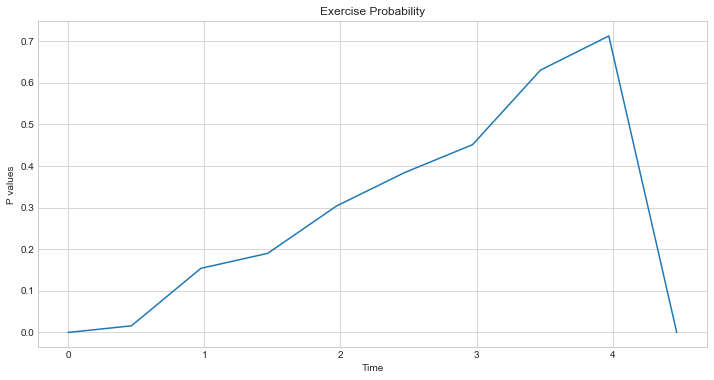

In [164]:
plt.figure(figsize=(12,6))
plt.plot(time_grid, exerciseProbability)
plt.title("Exercise Probability")
plt.xlabel("Time")
plt.ylabel("P values")
plt.show()

#### Confronto con Hull-White-Tree-model di Quantlib e Murex
#### Il prezzo di murex è calcolato con vola piecewise constant, mentre io ho considerato un sigma costante a 0.0040

In [165]:
modelhw = ql.HullWhite(t0_curve, 0.03, 0.0040)
enginehw = ql.TreeSwaptionEngine(modelhw, 50)
exercise = ql.BermudanExercise(calldates)
swaption = ql.Swaption(swap, exercise)
swaption.setPricingEngine(enginehw)
print("LSM simulation npv: %.4f" % npv_amc)
print("Quantlib NPV a t0: %.4f" % swaption.NPV())
print("Errore : %.8f%%" % ((npv_amc - swaption.NPV())/(notional*100)))

LSM simulation npv: 10523.0424
Quantlib NPV a t0: 10113.0643
Errore : 0.00000410%


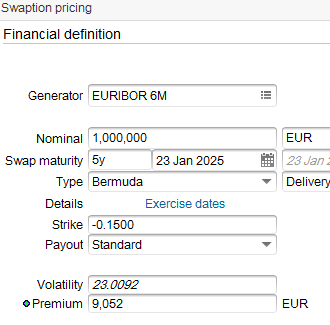

In [122]:
Image(filename='price.PNG')

#### Simulazione dei valori futuri dello swap per 50 path.Il procedimento è il seguente:
#### 1) Far girare la simulazione dello short rate(r) sulle date di call, campionando dalla distribuzione normale di r.
#### 2) Costruire una curva di discount factors in funzione di r per ogni path che parta da ogni data.
#### 3) Calcolare il valore ad ogni data futura dello swap per ogni path.
#### In figura --> Future exposure dello swap e future value delle due gambe(in azzurro sotto)

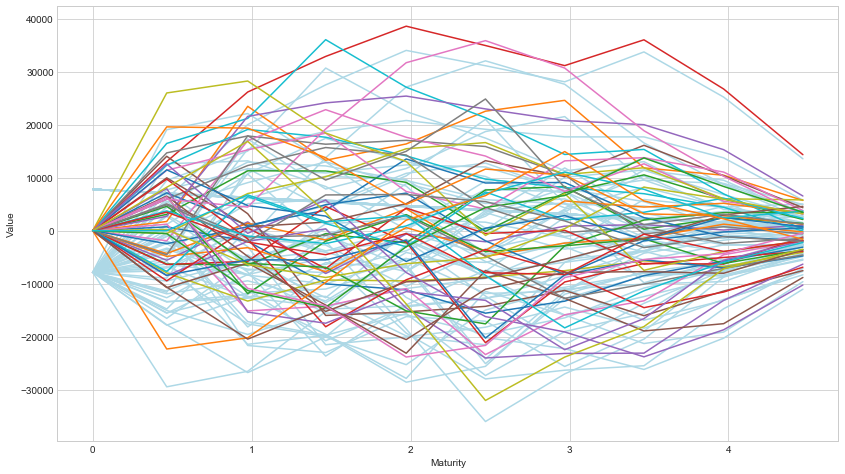

In [166]:
swapNPV, flt, fix,_,_,_  = swapSimulation(50)
fig = plt.figure(figsize=(14,8))
plt.plot(time_grid, -fix.T, color = "lightblue")
plt.plot(time_grid, flt.T, color = "lightblue")
plt.plot(time_grid, swapNPV.T)
plt.xlabel("Maturity")
plt.ylabel("Value")
plt.show()

#### Plot dell'approssimazione della "nuvola" di punti generati dalla simulazione.
#### Ogni punto raffigura il futuro payoff della swaption: max(swapNPV,0)
#### L'expected value a t condizionato a t-1 viene approssimato con un polinomio funzione di payoff e state variable
#### In questo caso è stato necessario standardizzare la variabile r_t per ottenere un approssimazione corretta

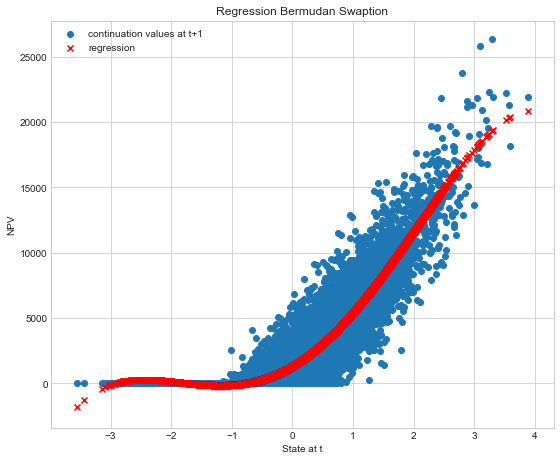

In [124]:
swapNPV, flt, fix, numeraires, y, r = swapSimulation(10000)
payoff = swapNPV[:,-1]/numeraires[:,-1]
payoff[payoff < 0] = 0
V = np.zeros_like(y)
V[:,-1] = payoff
m = len(time_grid) -1
ols_res = []
payoff = swapNPV[:,-1]/numeraires[:,-1]
payoff[payoff < 0] = 0
states = y[:, -2]
Y = np.column_stack((states, states**2, states**3, states**4))
Y = sm.add_constant(Y)
ols = sm.OLS(payoff, Y)   
ols_result = ols.fit()
cont_value_hat = np.sum(ols_result.params * Y, axis=1)

plt.figure(figsize=(9,7.5))
plt.scatter(states, payoff)
plt.scatter(states, cont_value_hat, marker='x', c='red')
plt.legend(["continuation values at t+1", "regression"])
plt.title("Regression Bermudan Swaption")
plt.xlabel("State at t")
plt.ylabel("NPV")
plt.show()

In [134]:
maturities = [ql.Period("3Y"),ql.Period("4Y"),ql.Period("6Y"),
              ql.Period("8Y"),ql.Period("10Y"),ql.Period("12Y"),
              ql.Period("15Y"), ql.Period("20Y"), ql.Period("30Y")]
modelhw = ql.HullWhite(t0_curve, 0.03, 0.0075)
enginehw = ql.TreeSwaptionEngine(modelhw, 50)
swaption_ql = np.zeros(len(maturities))
swaption_lsm = np.zeros(len(maturities))
date = []
for i, p in enumerate(maturities):
    ql.Settings.instance().setEvaluationDate(today)
    settlementDate = today + ql.Period("4d")
    maturity = settlementDate + p
    date.append(maturity)
    swap = makeSwap(settlementDate, maturity, notional, fixedRate, index) 
    callability = ql.Period("-10d")
    swap_fixed_schedule = list(swap.fixedSchedule())
    calldates = [calendar.advance(d, callability) for d in swap_fixed_schedule[1:-1]]
    date_grid = [today] + calldates 
    date_grid = np.unique(np.sort(date_grid))
    time_grid = np.vectorize(lambda x: ql.Actual365Fixed().yearFraction(today, x))(date_grid)
    dt = time_grid[1:] - time_grid[:-1]
    exercise = ql.BermudanExercise(calldates)
    swaption = ql.Swaption(swap, exercise)
    swaption.setPricingEngine(enginehw)
    swaption_ql[i] = swaption.NPV()
    swaption_lsm[i],_,_  = LSM_american(1000)    

#### Least Squares Monte Carlo contro QuantLib.TreeSwaptionEngine nel tempo

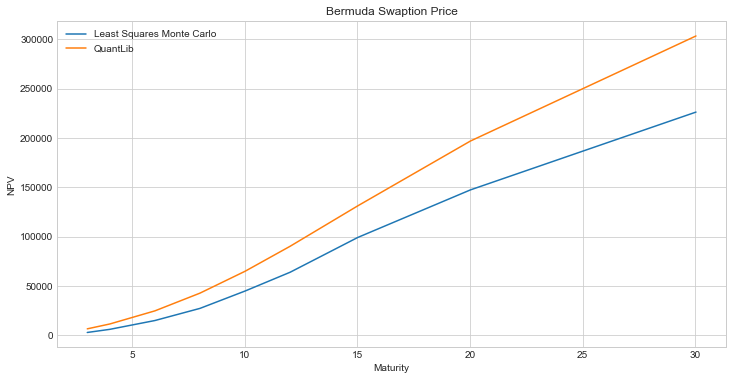

In [130]:
tempi = timeFromReference(np.array(date))
tempi.astype(int)
plt.figure(figsize =(12,6))
plt.plot(tempi, swaption_lsm)
plt.plot(tempi, swaption_ql)
plt.title("Bermuda Swaption Price")
plt.legend(["Least Squares Monte Carlo", "QuantLib"])
plt.xlabel("Maturity")
plt.ylabel("NPV")
plt.show()